In [1]:
import pandas as pd
import numpy as np
from openap import aero

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import BORDERS

from openap import top

## Define objective function

Here I am using a three hump camel function to simulate a complex cost gird. You can also test with the six hump_camel function for more local minima.

In [2]:
def gaussian(x, y):
    return -np.exp(-x**2 - y**2)


def three_hump_camel(x, y):
    return 2 * x**2 - 1.05 * x**4 + x**6 / 6 + x * y + y**2


def six_hump_camel(x, y):
    return (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x * (y) + (-4 + 4 * (y)**2) * (y)**2


In [3]:
# search ranges for the hump functions
x = np.linspace(-2, 2, 50)
y = np.linspace(-1, 1, 50)
z = np.linspace(0, 13_000, 10)

X, Y, Z = np.meshgrid(x, y, z)

V = gaussian(X, Y)

V = V - V.min()

# re-scale to our lon/lat grid
x_ = np.interp(x, (min(x), max(x)), (-10, 30))
y_ = np.interp(y, (min(y), max(y)), (35, 60))
X, Y, Z = np.meshgrid(x_, y_, z)


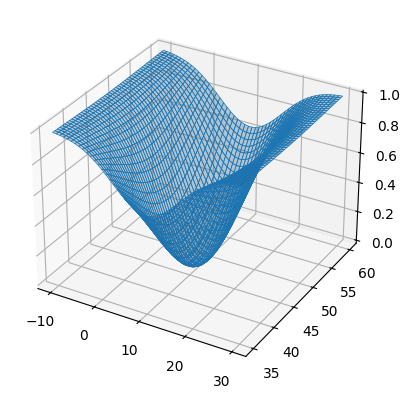

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={"projection": "3d"})

ax.plot_surface(
    X[:, :, 0],
    Y[:, :, 0],
    V[:, :, 0],
    edgecolor="tab:blue",
    lw=0.5,
    alpha=0.3,
)

plt.tight_layout()
plt.show()

## construct the cost data frame

Your own cost should have the same structure as follows

In [5]:
df_cost = pd.DataFrame(
    np.array([X, Y, Z, V]).reshape(4, -1).T,
    columns=["longitude", "latitude", "h", "cost"],
).sort_values(["h", "latitude", "longitude"], ascending=True)

df_cost

,longitude,latitude,h,cost
0,-10.000000,35.0,0.0,0.991182
10,-9.183673,35.0,0.0,0.988642
20,-8.367347,35.0,0.0,0.985314
30,-7.551020,35.0,0.0,0.981019
40,-6.734694,35.0,0.0,0.975560
...,...,...,...,...
24959,26.734694,60.0,13000.0,0.975560
24969,27.551020,60.0,13000.0,0.981019
24979,28.367347,60.0,13000.0,0.985314
24989,29.183673,60.0,13000.0,0.988642


## Set up the new objective function

General steps to set you own objective function / cost grid:

1. generate the interpolate model (linear) based on the grid data
2. define the objective function
3. pass the new objective function and interplant model to optimizer's `trajectory()` generator

In [6]:
optimizer = top.Cruise("A320", "EHAM", "LGAV", m0=0.85)
optimizer.init_conditions(h_min=32_000 * aero.ft, h_max=36_000 * aero.ft)
optimizer.fix_cruise_altitude()
optimizer.setup_dc(nodes=40)
optimizer.debug = False

# the inpterpolant required for the cost grid
interpolant = top.tools.interp_grid(
    longitude=df_cost.longitude.unique(),
    latitude=df_cost.latitude.unique(),
    height=df_cost.h.unique(),
    grid_value = df_cost.cost,
    shape="linear",
)

def obj_grid(x, u, dt, **kwargs):
    """The final cost is the compound of the 4d grid cost and fuel """
    # this grid cost unit is: cost/time
    grid_cost = optimizer.obj_grid_cost(x, u, dt, **kwargs) * dt
    fuel_cost = optimizer.obj_fuel(x, u, dt, **kwargs)
    return grid_cost * 2 + fuel_cost

# generate the flight trajectory
# interpolant is passed to trajectory() and then to obj_grid() internally
flight = optimizer.trajectory(
    objective=obj_grid,
    interpolant=interpolant,
    h_min=32_000 * aero.ft,
    h_max=36_000 * aero.ft,
)

## Visualize the trajectory

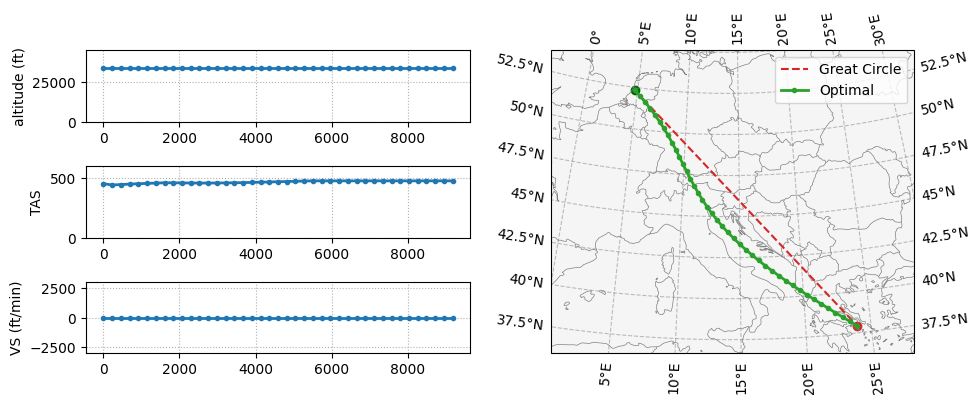

In [7]:
top.vis.trajectory(flight)
plt.show()

### Visualize the projected 4D cost along the trajectory 

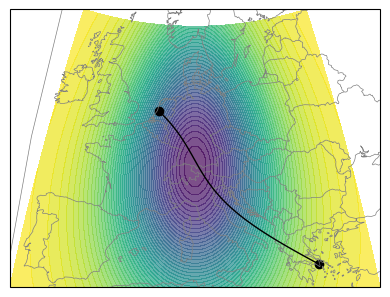

In [8]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(4, 4),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)

ax.set_extent([-10, 30, 35, 60])
ax.add_feature(BORDERS, lw=0.5, color="gray")
# ax.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
ax.coastlines(resolution="50m", lw=0.5, color="gray")

df_cost_pivot = df_cost.query(f"h==0").pivot(
    index="latitude", columns="longitude", values="cost"
)

lat, lon, val = df_cost_pivot.index.values, df_cost_pivot.columns.values, df_cost_pivot.values

ax.contourf(
    lon,
    lat,
    val,
    transform=ccrs.PlateCarree(),
    alpha=0.7,
    cmap="viridis",
    levels=50,
)


ax.plot(flight.longitude, flight.latitude, color="k", lw=1, transform=ccrs.PlateCarree())

ax.scatter(flight.longitude.iloc[0], flight.latitude.iloc[0], c="k", transform=ccrs.PlateCarree())
ax.scatter(flight.longitude.iloc[-1], flight.latitude.iloc[-1], c="k", transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
